In [7]:
import kagglehub
music_dataset_path = kagglehub.dataset_download('soumikrakshit/classical-music-midi')

print('Data source import complete.')

Data source import complete.


In [2]:
!pip install music21
!apt-get install -y lilypond
!pip install tensorflow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  ghostscript libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libkpathsea6 libptexenc1 libsynctex2 libteckit0 libtexlua53 libtexluajit2
  libwoff1 libzzip-0-13 lilypond-data lilypond-fonts lmodern poppler-data
  t1utils tex-common texlive-base texlive-binaries texlive-latex-base
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x lilypond-doc python3-lxml poppler-utils fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc
The following NEW packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-n

In [3]:

import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import wave
import os
import IPython.display as ipd
from music21 import *
from IPython.display import Image, Audio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split


In [4]:
midis_dir = "/kaggle/input/classical-music-midi/mozart" #path to Mozart midi files

In [5]:
np.random.seed(42) # setting a random seed

def all_files(folder_path, shuffle=True):
    """
    Returns all files in a folder
    """
    if shuffle:
        out = [os.path.join(folder_path, file)
                for file in os.listdir(folder_path)]
        np.random.shuffle(out)
        return out
    else:
        return [os.path.join(folder_path, file)
                for file in os.listdir(folder_path)]

In [8]:
all_midis = [] # we will parse all midis and add them into this list
for music in os.listdir(midis_dir):
    if music.endswith(".mid"):
        tr = os.path.join(midis_dir, music)
        midi = converter.parse(tr) # converting our midi files into note sequences
        all_midis.append(midi)

/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 1997 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Krueger'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiE

In [9]:
np.random.shuffle(all_midis) # shuffle our dataset

In [10]:
def extract_notes(file): # this function was forked in https://www.kaggle.com/karnikakapoor/music-generation-lstm
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

notes = extract_notes(all_midis)

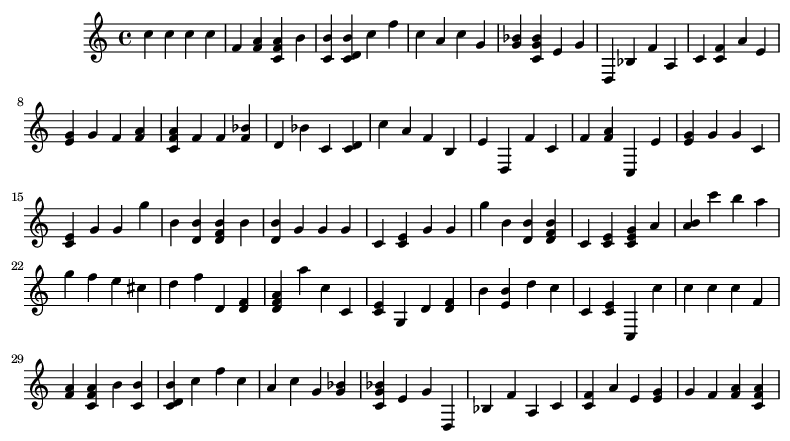

In [11]:
def show(music): # this function was forked in https://www.kaggle.com/karnikakapoor/music-generation-lstm
    display(Image(str(music.write("lily.png"))))

def chords_n_notes(Snippet): # this function was forked in https://www.kaggle.com/karnikakapoor/music-generation-lstm
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_n_notes(notes[:100])
show(Melody_Snippet)

In [12]:
#Helping function
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all dataset:", len(Corpus))

Total notes in all dataset: 55802


In [13]:
# Preprocessing the notes for the model
def prepare_sequences(notes, sequence_length=100):
    """ Prepare the sequences used by the Neural Network """
    # Get all unique pitches
    pitchnames = sorted(set(item for item in notes))
    n_vocab = len(pitchnames)

    # Create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # Create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    # Reshape and normalize input
    n_patterns = len(network_input)
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    network_input = network_input / float(n_vocab)

    # One-hot encode the output
    network_output = to_categorical(network_output)

    return network_input, network_output, note_to_int, pitchnames, n_vocab


In [14]:
# Prepare the data
sequence_length = 100
X, y, note_to_int, pitchnames, n_vocab = prepare_sequences(Corpus, sequence_length)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
# Create the RNN model
def create_model(input_shape, n_vocab):
    model = Sequential()
    model.add(LSTM(512, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(LSTM(512, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(LSTM(512))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_vocab, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = create_model((X.shape[1], X.shape[2]), n_vocab)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 512)       │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 512)       │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 229)            │        58,853 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,447,397 (20.78 MB)

 Trainable params: 5,444,325 (20.77 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [17]:
# Define a callback to save the best model during training
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

# Load the best model
model = keras.models.load_model('best_model.h5')


Epoch 1/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 4.6450
Epoch 1: val_loss improved from inf to 6.20542, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 52s 150ms/step - loss: 4.6439 - val_loss: 6.2054
Epoch 2/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 4.2631
Epoch 2: val_loss improved from 6.20542 to 4.78867, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 154ms/step - loss: 4.2629 - val_loss: 4.7887
Epoch 3/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 4.2015
Epoch 3: val_loss improved from 4.78867 to 4.22875, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 156ms/step - loss: 4.2015 - val_loss: 4.2288
Epoch 4/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 4.1847
Epoch 4: val_loss did not improve from 4.22875
349/349 ━━━━━━━━━━━━━━━━━━━━ 56s 161ms/step - loss: 4.1847 - val_loss: 4.3362
Epoch 5/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 4.1639
Epoch 5: val_loss did not improve from 4.22875
349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - loss: 4.1639 - val_loss: 4.3632
Epoch 6/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 4.1497
Epoch 6: val_loss improved from 4.22875 to 4.17206, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - loss: 4.1497 - val_loss: 4.1721
Epoch 7/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 4.1262
Epoch 7: val_loss did not improve from 4.17206
349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - loss: 4.1262 - val_loss: 4.4182
Epoch 8/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 4.0953
Epoch 8: val_loss did not improve from 4.17206
349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 163ms/step - loss: 4.0952 - val_loss: 5.1422
Epoch 9/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 4.0523
Epoch 9: val_loss improved from 4.17206 to 4.15783, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 58s 167ms/step - loss: 4.0522 - val_loss: 4.1578
Epoch 10/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 4.0150
Epoch 10: val_loss did not improve from 4.15783
349/349 ━━━━━━━━━━━━━━━━━━━━ 80s 162ms/step - loss: 4.0150 - val_loss: 4.8059
Epoch 11/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 3.9784
Epoch 11: val_loss improved from 4.15783 to 3.93475, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 161ms/step - loss: 3.9783 - val_loss: 3.9347
Epoch 12/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 3.9185
Epoch 12: val_loss did not improve from 3.93475
349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - loss: 3.9185 - val_loss: 4.5258
Epoch 13/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 3.8778
Epoch 13: val_loss improved from 3.93475 to 3.91670, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 161ms/step - loss: 3.8777 - val_loss: 3.9167
Epoch 14/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 3.8169
Epoch 14: val_loss did not improve from 3.91670
349/349 ━━━━━━━━━━━━━━━━━━━━ 58s 166ms/step - loss: 3.8168 - val_loss: 4.1494
Epoch 15/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 3.7507
Epoch 15: val_loss improved from 3.91670 to 3.74998, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 81s 164ms/step - loss: 3.7507 - val_loss: 3.7500
Epoch 16/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 3.6780
Epoch 16: val_loss did not improve from 3.74998
349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 164ms/step - loss: 3.6779 - val_loss: 4.3568
Epoch 17/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 3.5975
Epoch 17: val_loss improved from 3.74998 to 3.54925, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 81s 162ms/step - loss: 3.5975 - val_loss: 3.5492
Epoch 18/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 3.5327
Epoch 18: val_loss did not improve from 3.54925
349/349 ━━━━━━━━━━━━━━━━━━━━ 84s 168ms/step - loss: 3.5327 - val_loss: 3.6574
Epoch 19/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 3.4491
Epoch 19: val_loss improved from 3.54925 to 3.46546, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 58s 166ms/step - loss: 3.4491 - val_loss: 3.4655
Epoch 20/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 3.3976
Epoch 20: val_loss improved from 3.46546 to 3.36054, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 84s 171ms/step - loss: 3.3976 - val_loss: 3.3605
Epoch 21/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 3.3183
Epoch 21: val_loss improved from 3.36054 to 3.33717, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 59s 168ms/step - loss: 3.3183 - val_loss: 3.3372
Epoch 22/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 3.2543
Epoch 22: val_loss improved from 3.33717 to 3.23598, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 171ms/step - loss: 3.2543 - val_loss: 3.2360
Epoch 23/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 3.1696
Epoch 23: val_loss improved from 3.23598 to 3.18113, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 58s 166ms/step - loss: 3.1696 - val_loss: 3.1811
Epoch 24/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 3.0972
Epoch 24: val_loss improved from 3.18113 to 3.12995, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 58s 167ms/step - loss: 3.0972 - val_loss: 3.1300
Epoch 25/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 3.0438
Epoch 25: val_loss improved from 3.12995 to 3.06453, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 170ms/step - loss: 3.0438 - val_loss: 3.0645
Epoch 26/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2.9711
Epoch 26: val_loss improved from 3.06453 to 3.01383, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 58s 166ms/step - loss: 2.9711 - val_loss: 3.0138
Epoch 27/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.9177
Epoch 27: val_loss improved from 3.01383 to 2.93508, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 84s 171ms/step - loss: 2.9177 - val_loss: 2.9351
Epoch 28/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.8407
Epoch 28: val_loss improved from 2.93508 to 2.88609, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - loss: 2.8408 - val_loss: 2.8861
Epoch 29/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.7989
Epoch 29: val_loss did not improve from 2.88609
349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - loss: 2.7989 - val_loss: 3.0079
Epoch 30/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 2.7257
Epoch 30: val_loss improved from 2.88609 to 2.80185, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - loss: 2.7258 - val_loss: 2.8019
Epoch 31/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.6722
Epoch 31: val_loss improved from 2.80185 to 2.77256, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - loss: 2.6723 - val_loss: 2.7726
Epoch 32/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2.6113
Epoch 32: val_loss improved from 2.77256 to 2.73029, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 58s 165ms/step - loss: 2.6114 - val_loss: 2.7303
Epoch 33/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 2.5758
Epoch 33: val_loss improved from 2.73029 to 2.65758, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 169ms/step - loss: 2.5759 - val_loss: 2.6576
Epoch 34/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.4983
Epoch 34: val_loss improved from 2.65758 to 2.63263, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - loss: 2.4984 - val_loss: 2.6326
Epoch 35/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.4639
Epoch 35: val_loss improved from 2.63263 to 2.59151, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - loss: 2.4640 - val_loss: 2.5915
Epoch 36/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.4214
Epoch 36: val_loss improved from 2.59151 to 2.58404, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 81s 169ms/step - loss: 2.4214 - val_loss: 2.5840
Epoch 37/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 2.3765
Epoch 37: val_loss improved from 2.58404 to 2.50360, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 58s 167ms/step - loss: 2.3766 - val_loss: 2.5036
Epoch 38/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 2.3159
Epoch 38: val_loss did not improve from 2.50360
349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - loss: 2.3160 - val_loss: 2.5236
Epoch 39/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.2794
Epoch 39: val_loss improved from 2.50360 to 2.49725, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 170ms/step - loss: 2.2795 - val_loss: 2.4973
Epoch 40/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 2.2448
Epoch 40: val_loss improved from 2.49725 to 2.43194, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 171ms/step - loss: 2.2448 - val_loss: 2.4319
Epoch 41/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.1884
Epoch 41: val_loss did not improve from 2.43194
349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - loss: 2.1884 - val_loss: 2.4831
Epoch 42/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.1798
Epoch 42: val_loss did not improve from 2.43194
349/349 ━━━━━━━━━━━━━━━━━━━━ 81s 168ms/step - loss: 2.1798 - val_loss: 2.9682
Epoch 43/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 2.1379
Epoch 43: val_loss improved from 2.43194 to 2.36587, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 171ms/step - loss: 2.1379 - val_loss: 2.3659
Epoch 44/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.0910
Epoch 44: val_loss improved from 2.36587 to 2.31200, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - loss: 2.0910 - val_loss: 2.3120
Epoch 45/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 2.0536
Epoch 45: val_loss did not improve from 2.31200
349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - loss: 2.0538 - val_loss: 2.3347
Epoch 46/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 2.0017
Epoch 46: val_loss improved from 2.31200 to 2.29437, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 81s 169ms/step - loss: 2.0018 - val_loss: 2.2944
Epoch 47/50
348/349 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 1.9883
Epoch 47: val_loss did not improve from 2.29437
349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 168ms/step - loss: 1.9884 - val_loss: 2.2949
Epoch 48/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 1.9261
Epoch 48: val_loss did not improve from 2.29437
349/349 ━━━━━━━━━━━━━━━━━━━━ 83s 170ms/step - loss: 1.9262 - val_loss: 2.4264
Epoch 49/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 1.8928
Epoch 49: val_loss did not improve from 2.29437
349/349 ━━━━━━━━━━━━━━━━━━━━ 81s 169ms/step - loss: 1.8929 - val_loss: 2.4582
Epoch 50/50
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 1.8931
Epoch 50: val_loss improved from 2.29437 to 2.18162, saving model to best_model.h5


349/349 ━━━━━━━━━━━━━━━━━━━━ 82s 170ms/step - loss: 1.8931 - val_loss: 2.1816


In [18]:
# Function to generate music
def generate_music(model, note_to_int, pitchnames, start_sequence, length=500):
    """ Generate music from the model """
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    # Prepare the initial sequence
    pattern = [note_to_int[char] for char in start_sequence]
    prediction_output = []

    # Generate notes
    for note_index in range(length):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:]

    return prediction_output


Generated music with 200 notes


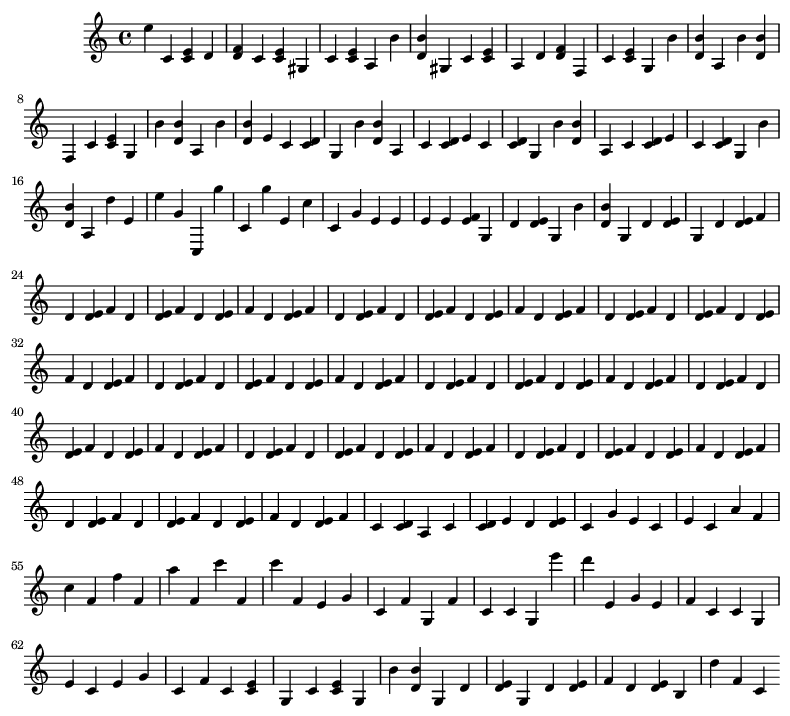

In [19]:
# Generate new music
def generate_and_play(start_sequence=None, length=200):
    """ Generate and play music with controllable length """
    if start_sequence is None:
        # Use a random sequence from the corpus as starting point
        start_idx = np.random.randint(0, len(Corpus) - sequence_length)
        start_sequence = Corpus[start_idx:start_idx + sequence_length]

    generated_notes = generate_music(model, note_to_int, pitchnames, start_sequence, length)

    # Convert the generated notes to a music21 stream and play
    generated_music = chords_n_notes(generated_notes)

    print(f"Generated music with {length} notes")
    show(generated_music)

    # Save to MIDI file
    generated_music.write('midi', fp='generated_music.mid')

    # Play the audio
    return Audio('generated_music.mid')

# Example usage:
# generate_and_play(length=300)  # Generates 300 notes
# generate_and_play(start_sequence=notes[:100], length=400)  # Uses specific starting sequence

# Generate and play a sample (200 notes)
generate_and_play(length=200)


In [20]:
from google.colab import files
files.download('best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
files.download('generated_music.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>